In [75]:
import importlib
import tensorflow as tf
importlib.reload(tf)

<module 'tensorflow' from '/root/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/__init__.py'>

In [76]:
# Dataset direction

train_dir = './Data/train'
validation_dir = './Data/valid'

In [77]:
# Load Data and apply data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=(0.5, 1.0),
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.15,
    brightness_range=[0.7, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3318 images belonging to 6 classes.
Found 307 images belonging to 6 classes.


In [78]:
# Define model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, regularizers

base_model = ResNet50V2(
    weights='./resnet50v2_weights.h5',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3)
)

for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [79]:
# Define compile methods and set callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.001
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(
    filepath='best_model_epoch{epoch:02d}_valacc{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
)
]

In [80]:
# Calculate class weights to compensate for class imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [81]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

steps_per_epoch = (train_generator.samples +batch_size - 1) //batch_size
validation_steps = (validation_generator.samples +batch_size - 1) //batch_size

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
104/104 [==============================] - ETA: 0s - loss: 6.2671 - accuracy: 0.6106
Epoch 1: val_accuracy improved from -inf to 0.55049, saving model to best_model_epoch01_valacc0.55.h5
104/104 [==============================] - 47s 379ms/step - loss: 6.2671 - accuracy: 0.6106 - val_loss: 3.9919 - val_accuracy: 0.5505 - lr: 0.0010
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 1.9001 - accuracy: 0.7556
Epoch 2: val_accuracy improved from 0.55049 to 0.73941, saving model to best_model_epoch02_valacc0.74.h5
104/104 [==============================] - 41s 392ms/step - loss: 1.9001 - accuracy: 0.7556 - val_loss: 1.4318 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 3/20
104/104 [==============================] - ETA: 0s - loss: 1.1477 - accuracy: 0.7818
Epoch 3: val_accuracy improved from 0.73941 to 0.77850, saving model to best_model_epoch03_valacc0.78.h5
104/104 [==============================] - 41s 394ms/step - loss: 1.1477 - accuracy: 0.7818 - val_loss: 0.

In [82]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

10/10 [==============================] - 1s 66ms/step - loss: 0.5118 - accuracy: 0.8599
Validation Loss: 0.5118
Validation Accuracy: 0.8599


10/10 [==============================] - 1s 68ms/step


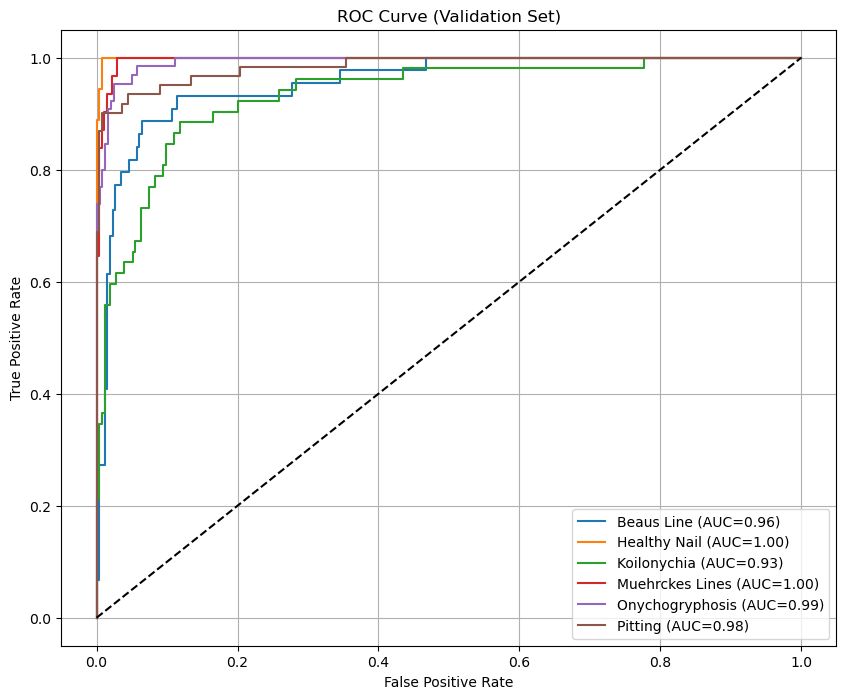

In [83]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate prediction probabilities
validation_generator.reset()
probs = model.predict(
    validation_generator, 
    steps=(validation_generator.samples + batch_size - 1) // batch_size
)

# one-hot encoding
true_classes = validation_generator.classes
num_classes = len(validation_generator.class_indices)
class_labels = list(validation_generator.class_indices.keys())
true_one_hot = np.eye(num_classes)[true_classes]

# Calculate and visualize ROC and AUC by class
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_one_hot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (Validation Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

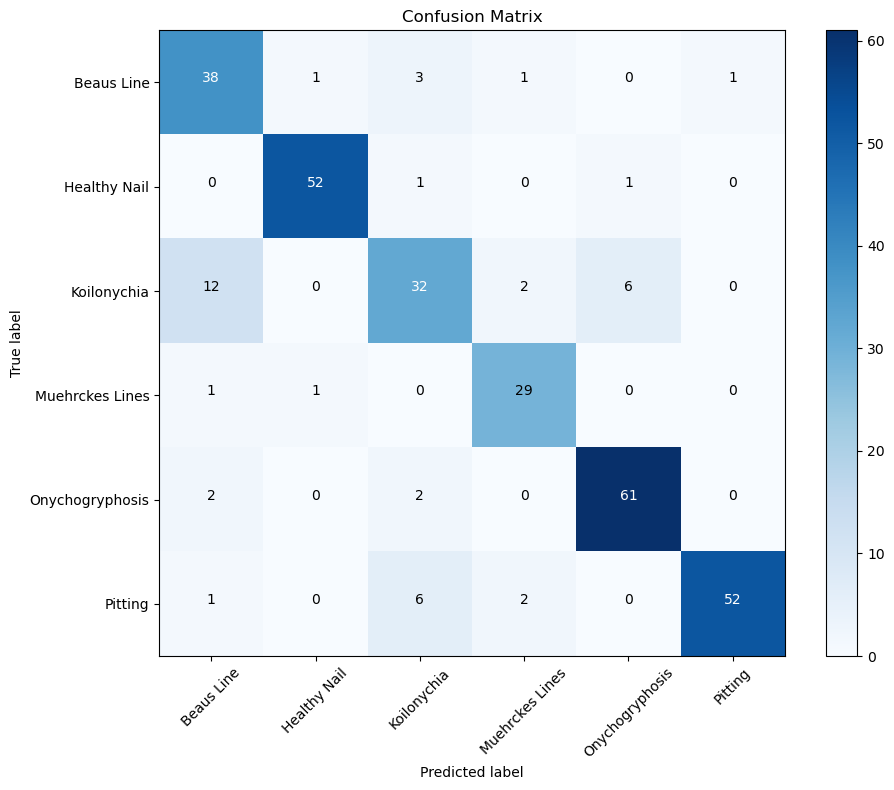

In [84]:
# confusion matrix
from sklearn.metrics import confusion_matrix

predicted_classes = np.argmax(probs, axis=1)
true_classes = validation_generator.classes
conf_matrix = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
 
plot_confusion_matrix(conf_matrix, class_labels)

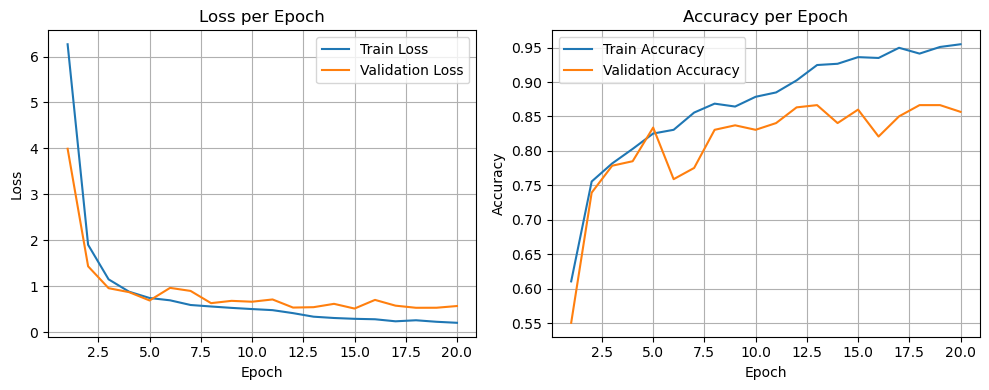

In [85]:
# Utilizing historical values in history objects
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
model.save('./ResNet50V2_model.h5')

In [87]:
import pickle

with open('ResNet50V2_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [88]:
data_dir = './Data/test'
class_labels = sorted([
    entry.name for entry in os.scandir(data_dir) if entry.is_dir()
])
print(class_labels)

['Beaus Line', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting']


In [89]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_labels, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)        # shape: (1, 128, 128, 3)
    img_array = img_array / 255.0

    # predict
    print(img_path)
    preds = model.predict(img_array)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_label = class_labels[pred_idx]
    confidence = preds[0][pred_idx]

    print(f"Predict result: {pred_label} (confidence: {confidence:.3f})")
    return pred_label, confidence

img_path = "./Data/test/Healthy Nail/81.jpg"

predict_image(img_path, model, class_labels)

./Data/test/Healthy Nail/81.jpg
1/1 [==============================] - 1s 723ms/step
Predict result: Healthy Nail (confidence: 0.971)


('Healthy Nail', 0.9714427)

Data/test/Pitting/20.jpg
1/1 [==============================] - 0s 37ms/step
Predict result: Pitting (confidence: 0.997)
1/1 [==============================] - 0s 37ms/step


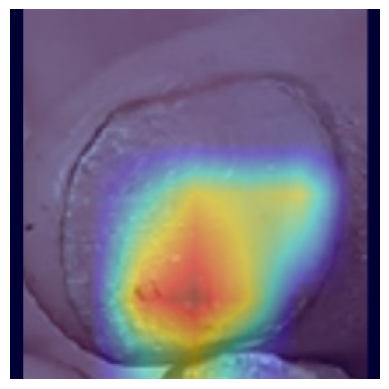

In [90]:
import cv2

def get_gradcam(model, img_array, class_index, conv_layer_name):
    base_model = model.get_layer('resnet50v2')
    conv_layer = base_model.get_layer(conv_layer_name)
    grad_model = tf.keras.models.Model(
        [base_model.input], 
        [conv_layer.output, base_model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[..., i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    return heatmap

img_path = 'Data/test/Pitting/20.jpg'
predict_image(img_path, model, class_labels)
img = cv2.imread(img_path)
img_input = img / 255.0
img_input = np.expand_dims(img_input, axis=0)

preds = model.predict(img_input)
pred_class = np.argmax(preds)

heatmap = get_gradcam(model, img_input, pred_class, 'conv5_block3_out')

# Overlay
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()